In [155]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import pandas as pd
import datetime as dt

# Kalman filter

Based on Durbin Koopman


For generic state-space systems like (Hamilton's notation):



$$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

$$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t} 
\underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


$$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$




Where

* $p$ is the number of observed variables
* $m$ is the number of latent states
* $r$ is the number of disturbances (?)

In [193]:
class KalmanFilter():
#     """
#         Based on Durbin Koopman


#         For generic state-space systems like (Hamilton's notation):



#         $$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

#         $$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t} 
#         \underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


#         $$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$
        
#         Where

#         * $p$ is the number of observed variables
#         * $m$ is the number of latent states
#         * $r$ is the number of disturbances 
        
#     """
    
    def __init__(self,y,Z,H,T,Q,a1,P1,R):
        
        self.yindex = y.index
        self.ycols = y.columns
        self.p = y.shape[1]
        self.n = y.shape[0]
        self.y = np.array(y)
        self.Z = np.array(Z)
        self.H = np.array(H)
        self.T = np.array(T)
        self.Q = np.array(Q)
        self.a = [np.array(a1)]
        self.P = [np.array(P1)]
        self.vt = []
        self.Ft = []
        self.Kt = []
        self.ZT = Z.T #To avoid transposing it several times
        self.R = R
        
        
    def runFilter(self,):
        # Implemented with non time varying coefficients
        
#         for i in range(0,self.n-1):
        for i in range(0,1):
            print(self.y[i].shape)
            print(self.Z.shape)
            print(self.a[i].shape)
            self.vt.append(self.y[i] - np.dot(self.Z,self.a[i]))            
            
            self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)
            
            Finv = inv(self.Ft[i])            
            
#             print(self.P[i].shape)
#             print(self.ZT.shape)
#             print(Finv.shape)
#             print(self.vt[i].shape)
            self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])
            
            self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])
        
            self.a.append(self.T.dot(self.a[i]))
            
            self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(Q).dot(R.T))
        
        

# Pandas or numpy dot product ?

In [31]:
df = {
    dt.datetime(2017,1,1) : np.random.randn(4),
    dt.datetime(2017,1,2) : np.random.randn(4),
    dt.datetime(2017,1,3) : np.random.randn(4),
    dt.datetime(2017,1,4) : np.random.randn(4),
}

In [32]:
df = pd.DataFrame(df).T
df

,0,1,2,3
2017-01-01,0.185268,-0.081558,-0.139563,-1.678714
2017-01-02,0.846836,-0.603273,-1.766571,-0.648029
2017-01-03,-2.925527,1.013188,0.623278,-1.242312
2017-01-04,-0.365710,1.037992,-0.164857,0.956719
2017-01-05,1.637818,-0.081899,0.385356,1.508859


In [8]:
dfnp = np.array(df)
dfnp

array([[-1.19564393,  0.81326495, -0.89616301, -2.11394964],
       [ 0.14056282, -0.67615196, -1.16549483, -0.00892578],
       [-1.08412815, -0.55098882,  1.0134736 ,  0.06268713],
       [-0.16320344, -0.22005464,  0.91561726, -1.86794598]])

In [15]:
%%timeit -n 10000

df.dot(df.T)


10000 loops, best of 3: 272 µs per loop


In [16]:
%%timeit -n 10000

np.dot(dfnp,dfnp.T)

10000 loops, best of 3: 1.73 µs per loop


Numpy as WAY faster

# Numpy or python append?

Which one is faster to append new values and access the last one

In [17]:
lis = [1.756756,2.123123,3.24234]
nplis = np.array(lis)

In [29]:
%%timeit -n 10000

lis.append(7.21342)

lis[-1] + 3.46785

10000 loops, best of 3: 131 ns per loop


In [30]:
%%timeit -n 10000
np.append(nplis,7)
nplis[-1] + 3.46785

10000 loops, best of 3: 7.44 µs per loop


Python append is way faster

# Dummy data for the KF with non time-varying parameters

For convenience: 

$$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

$$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t} 
\underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


$$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

## Local Level model

$$ y_t = \mu_t + \epsilon_t, \qquad \epsilon \sim NID(0, \sigma^2_ \epsilon) $$
$$ \mu_{t+1} = \mu_t + \eta_t, \qquad \eta_t \sim NID(0,\sigma^2_ \eta) $$

In [90]:
m = 2
p = 4


Z = [[0.3,0.7],[0.1,0],[0.5,0.5],[0,0.3]]


Z = pd.DataFrame(Z)

H = pd.DataFrame(np.diag([1,2,3,4]))


T = pd.DataFrame(np.identity(2))
R = pd.DataFrame(np.identity(2))

Q = pd.DataFrame(np.diag([0.2,0.4]))

In [130]:
n = 1000 #sample size
mut = [np.array([1,10]).reshape(m,1)]
yt = [np.array([0,0,0,0]).reshape(p,1)]

for i in range(0,1000):
    
    temp = np.multiply(np.random.randn(m,1),np.diag(Q).reshape((m,1)))
    temp = R.dot(temp)
    temp = temp + mut[i]
    mut.append(temp)  
    
    temp = np.multiply(np.random.randn(p,1),np.diag(H).reshape((p,1)))
    yt.append(temp+Z.dot(mut[i+1]))

    
yt[0] = pd.DataFrame(yt[0])   
y = pd.concat(yt,axis=1).T.reset_index(drop=True)

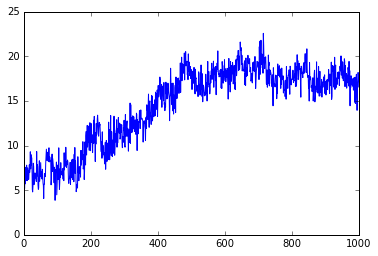

In [131]:
y[0].plot()

In [194]:
kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  np.array([0,0]).reshape(m,1),
                  np.diag(np.array([1,1])),
                  R)

kf.runFilter()

(4,)
(4, 2)
(2, 1)


In [197]:
kf.vt[0]

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [198]:
kf.y[0]

array([ 0.,  0.,  0.,  0.])

In [199]:
kf.Z

array([[ 0.3,  0.7],
       [ 0.1,  0. ],
       [ 0.5,  0.5],
       [ 0. ,  0.3]])

In [202]:
kf.a[0]

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [201]:
kf.Z.dot(kf.a[0])

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])